In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-price/TSLA.csv


**Import library**

In [2]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
import tensorflow as tf
import numpy as np
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
dir_path='../input/tesla-stock-price'

.

***python Class for Pre-processing***

In [3]:
class timeseries_pre():
    def __init__(self,dir_path):
        self.dir_path=dir_path
        
    def read_files(self):
        comp_dir = Path(self.dir_path)
        train_df = pd.read_csv(comp_dir / 'TSLA.csv',parse_dates=['Date'])
        for i,col in enumerate(train_df.columns):
            print(i,col)
        return train_df.iloc[:]
    
    def transform_lablel(self,lb,train_df):
        name=[train_df.columns[i] for i in list(lb)]
        for name in list(name):
            le = LabelEncoder()
            label = le.fit_transform(train_df[name])
            train_df.drop((name), axis=1, inplace=True)
            train_df[name] = label
        return train_df

    def sequance_series(self,data, window=1, lag=1, dropnan=True):
        cols, names = list(), list()
        for i in range(window, 0, -1):
            cols.append(data.shift(i))
            names += [('%s(t-%d)' % (col, i)) for col in data.columns]
        cols.append(data)
        names += [('%s(t)' % (col)) for col in data.columns]
        cols.append(data.shift(-lag))
        names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    def multi_sequance_data(self,window=10,lag=1,df_for_training_scaled=None,target_index=0):
        trainX = []
        trainY = []
        n_future = lag  
        n_past = window 
        for i in range(n_past, len(df_for_training_scaled) - n_future +1):
            trainX.append(df_for_training_scaled[i - window:i, 0:df_for_training.shape[1]])
            trainY.append(df_for_training_scaled[i + lag - 1:i + lag,target_index])
        trainX, trainY = np.array(trainX), np.array(trainY)
        print('trainX shape ==> {}'.format(trainX.shape))
        print('trainY shape ==> {}'.format(trainY.shape))

        return trainX,trainY

,

**Pre-processing EDA**

In [4]:
m=timeseries_pre(dir_path)
train=m.read_files()

0 Date
1 Open
2 High
3 Low
4 Close
5 Adj Close
6 Volume


In [5]:
train=train.set_index("Date").drop(columns=["Volume"])
train

,Open,High,Low,Close,Adj Close
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000
...,...,...,...,...,...
2023-03-31,197.529999,207.789993,197.199997,207.460007,207.460007
2023-04-03,199.910004,202.690002,192.199997,194.770004,194.770004
2023-04-04,197.320007,198.740005,190.320007,192.580002,192.580002


In [6]:
target=train["Open"]
target

Date
2010-06-29      1.266667
2010-06-30      1.719333
2010-07-01      1.666667
2010-07-02      1.533333
2010-07-06      1.333333
                 ...    
2023-03-31    197.529999
2023-04-03    199.910004
2023-04-04    197.320007
2023-04-05    190.520004
2023-04-06    183.080002
Name: Open, Length: 3216, dtype: float64

<AxesSubplot:xlabel='Date'>

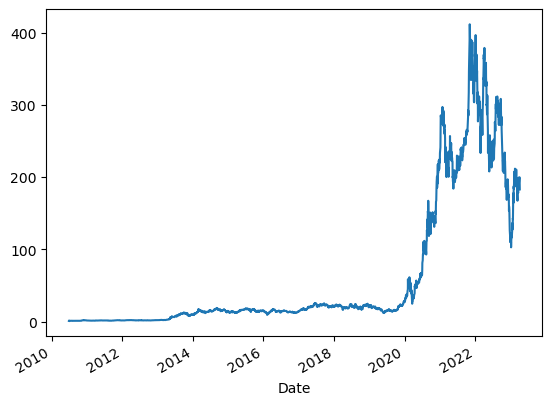

In [7]:
target.plot()

In [8]:
window=14
lag=1

df_for_training = train.astype(float)
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training_scaled.shape)

(3216, 5)


In [9]:
trainX,trainY = m.multi_sequance_data(window=window,lag=lag,df_for_training_scaled=df_for_training_scaled,target_index=0)
print("target name  ==> ",train.columns[0])

trainX shape ==> (3202, 14, 5)
trainY shape ==> (3202, 1)
target name  ==>  Open


.

***python Class For all models***
*-tune hyperparamters*

In [10]:

class all_model():
    def __init__(self,trainX,trainY):
        self.trainX=trainX
        self.trainX=trainY
     
    def cnn(self,lr=0.001,batch_size=160,epochs=1000, patience=10,validation_split=0.1,plot=True):
        model_cnn = Sequential()
        model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
        model_cnn.add(MaxPooling1D(pool_size=2))
        model_cnn.add(Flatten())
        model_cnn.add(Dense (64, activation='relu'))
        model_cnn.add(Dropout(0.1))
        model_cnn.add(Dense (128, activation='relu'))
        model_cnn.add(Dropout(0.1))
        model_cnn.add(Dense (34, activation='relu'))
        model_cnn.add(Dropout(0.2))
        model_cnn.add(Dense(trainY.shape[1]))
        model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr))
        model_cnn.summary()
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
        cnn_history = model_cnn.fit(trainX, trainY,validation_split=validation_split, callbacks=[callback],batch_size=batch_size,epochs=epochs, verbose=1)
        loss=[]
        val_loss=[]
        loss.append(cnn_history.history['loss'])
        val_loss.append(cnn_history.history['val_loss'])
        
        if plot is True:
            plt.plot(loss[0], label='Training loss')
            plt.plot(val_loss[0], label='Validation loss')
            plt.legend()
            
        return model_cnn
    
    
    def lstm(self,lr=0.001,batch_size=160,epochs=1000,validation_split=0.1 ,patience=10,plot=True):
        lstm = Sequential()
        lstm.add(LSTM(256, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
        lstm.add(Dense(128))
        lstm.add(Dropout(0.3))
        lstm.add(Dense(64))
        lstm.add(Dense(32))
        lstm.add(Dense(1))
        lstm.compile(loss='mse', optimizer=optimizers.Adam(lr))
        lstm.summary()

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
        lstm_history = lstm.fit(trainX, trainY,validation_split=validation_split, callbacks=[callback],batch_size=batch_size,epochs=epochs, verbose=1)
        loss=[]
        val_loss=[]
        loss.append(lstm_history.history['loss'])
        val_loss.append(lstm_history.history['val_loss'])
        
        if plot is True:
            plt.plot(loss[0], label='Training loss')
            plt.plot(val_loss[0], label='Validation loss')
            plt.legend()
            
        return lstm
    
    def cnnlstm(self,lr=0.001,batch_size=160,epochs=1000,validation_split=0.1, patience=10,plot=True): 
        a,b,c,d=trainX.shape[0],1,trainX.shape[1],trainX.shape[2]
        trainX1=trainX.reshape(a,b,c,d)
        cnn_lstm = Sequential()
        cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, trainX1.shape[2], trainX1.shape[3])))
        cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        cnn_lstm.add(TimeDistributed(Flatten()))
        cnn_lstm.add(TimeDistributed(Dropout(0.2)))
        cnn_lstm.add(LSTM(64, activation='relu'))
        cnn_lstm.add(Dense(32))
        cnn_lstm.add(Dense(1))
        cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr))
        cnn_lstm.summary()

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
        cnn_lstm_history = cnn_lstm.fit(trainX1, trainY,validation_split=validation_split, callbacks=[callback],batch_size=batch_size,epochs=epochs, verbose=1)
        loss=[]
        val_loss=[]
        loss.append(cnn_lstm_history.history['loss'])
        val_loss.append(cnn_lstm_history.history['val_loss'])
        
        if plot is True:
            plt.plot(loss[0], label='Training loss')
            plt.plot(val_loss[0], label='Validation loss')
            plt.legend()
            
        return cnn_lstm,trainX1     
    
    def plot_PvsA(self,prediction, df_for_training,train,scaler,title="cnn"):
        prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
        y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
        import sklearn
        mape=sklearn.metrics.mean_absolute_percentage_error(train['Open'][-len(y_pred_future)::], y_pred_future)
        R2_score= sklearn.metrics.r2_score(train['Open'][-len(y_pred_future)::], y_pred_future)
        fig, ax = plt.subplots(figsize=(8, 3))
        font = {'family': 'serif'}
        ax.plot(train['Open'][-len(y_pred_future)::].index,y_pred_future,label='Predicted')
        ax.plot(train['Open'][-len(y_pred_future)::].index,train['Open'][-len(y_pred_future)::],label='True')
        ax.set_xlabel('Sales',font='serif') 
        ax.set_ylabel('Date',font='serif') 
        ax.set_title(label="Prediction Vs Actual plot _"+title+"__ MAPE ="+str(mape.round(2))+"__ R2 ="+str(R2_score.round(3)),
                  fontsize=10,
                  color="darkred",font='serif')
        ax.legend(prop=font)
        plt.show()

In [11]:
Prediction_days=150
model=all_model(trainX,trainY)


# ***CNN for sales Forecasting***

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 128)           1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                        

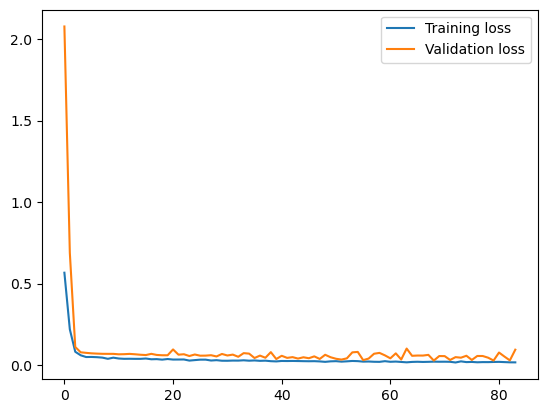

In [12]:
cnn_model=model.cnn(lr=0.0001,batch_size=164,epochs=1000, patience=15,plot=True)
prediction_cnn=cnn_model.predict(trainX[-Prediction_days:])


# ***LSTM for sales Forecasting***

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 13, 128)           1408      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                49216     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                      

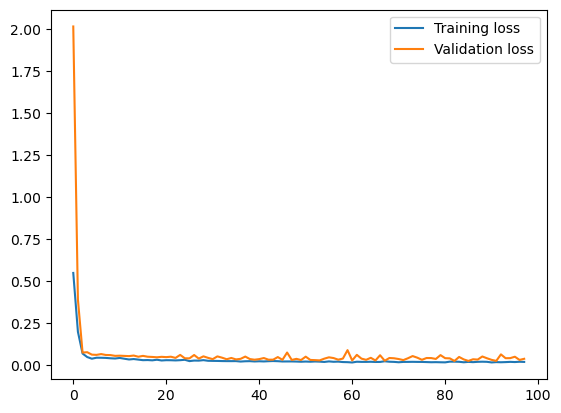

In [13]:
lstm_model=model.cnn(lr=0.0001,batch_size=164,epochs=1000, patience=15,plot=True)
prediction_lstm = lstm_model.predict(trainX[-Prediction_days:])


# ***CNN-LSTM for sales Forecasting***

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 14, 128)    768       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 7, 128)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 896)        0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 896)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)               

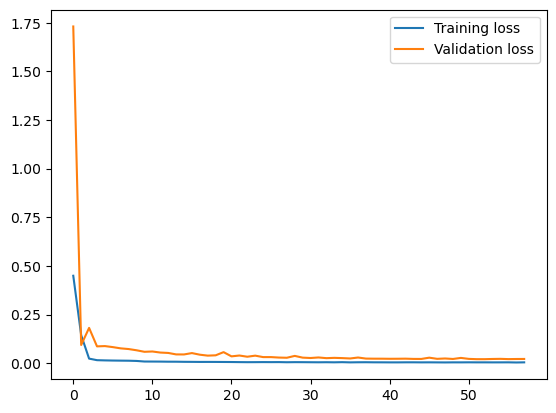

In [14]:
cnn_lstm_model,trainx  = model.cnnlstm(lr=0.0001,batch_size=164,epochs=1000, patience=5,plot=True)
prediction_cnn_lstm = cnn_lstm_model.predict(trainx[-Prediction_days:])


# ***Results***

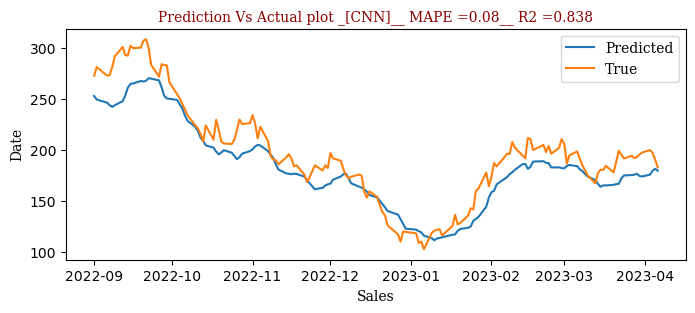

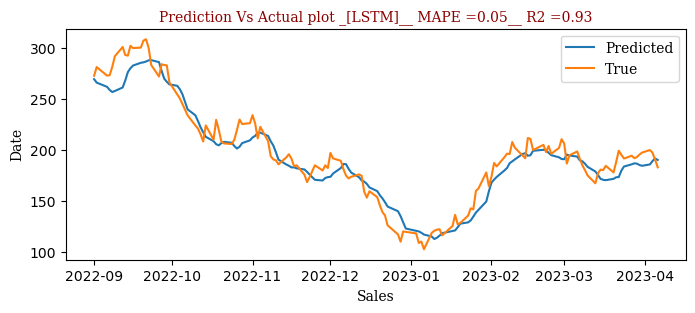

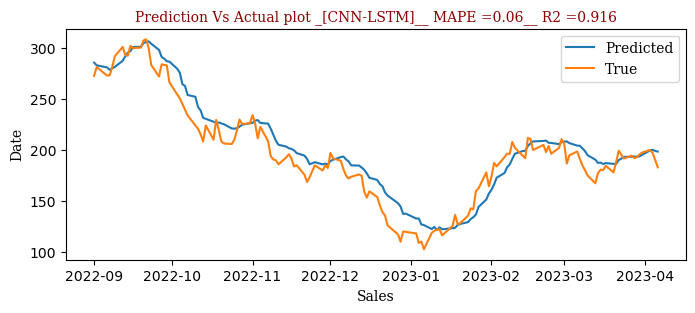

In [15]:
model.plot_PvsA(prediction_cnn, df_for_training,train,scaler,title="[CNN]")
model.plot_PvsA(prediction_lstm, df_for_training,train,scaler,title="[LSTM]")
model.plot_PvsA(prediction_cnn_lstm, df_for_training,train,scaler,title="[CNN-LSTM]")
